<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🍿Netflix</font>](https://www.kaggle.com/c/12feb24jh-netflix/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade imgaug==0.2.5 > log.txt  # avoids warning/conflict with scipy upgrade
!pip install --upgrade scipy >>log.txt  # upgrades 1.4 to 1.8

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 12feb24jh-netflix        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 12feb24jh-netflix
Using competition: 12feb24jh-netflix
  teamId  teamName              submissionDate       score         
--------  --------------------  -------------------  ------------  
11671804  Joshua Stephani       2024-02-24 23:59:07  0.4222000000  
11667790  Noah Giles JHU        2024-02-25 00:05:07  0.4179000000  
11681296  Daniel Kim            2024-02-24 23:47:01  0.4162000000  
11667789  Joni Vrapi            2024-02-24 18:39:15  0.4160000000  
11663470  Jared Clabough        2024-02-25 00:59:42  0.4160000000  
11677649  Nick Sarfaraz         2024-02-24 23:47:30  0.4160000000  
11529808  🍿Baseline🐍            2023-09-09 16:37:37  0.4137000000  
11655528  Anthony Vasquez       2024-02-25 00:22:18  0.4137000000  
11655672  Tarun Nadipalli       2024-02-19 03:35:01  0.4137000000  
11660080  Aaron M Collinsworth  2024-02-24 23:56:11  0.4137000000  
11664025  Harrison Bai          2024-02-25 

In [ ]:
%%time
%%capture
%reset -f
!cp metadata.json METADATA
!pip -q install scikit-surprise
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, plotly.express as px, surprise
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=1000, precision=2, edgeitems=20, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.44 s, sys: 371 ms, total: 2.81 s
Wall time: 19.9 s


The matrix below contains ratings that users (user id or `uid`) have given to the movies (movie ID or `mid`). It is 85% blank, but the original dataset was 99% sparse (with ~1 rating per user) [&#127910;](https://youtu.be/ImpV70uLxyw). Your task is not to fill the whole matrix, but to impute `NaN` values in `XY_Netflix.csv`, which is an equivalent representation of `XY_Netflix_matrix.csv`. This is a collaborative filtering problem, where observations and features have some implicit relation. Recall that typically we expect independent observations in a sample (unless we have a time series or video of image frames, etc.). Here our model needs to learn and leverage the dependencies from observed movie ratings. Clustering techniques might be more intuitive here. [Truncated SVD](https://scikit-learn.org/stable/modules/decomposition.html#lsa) is also popular. Supervised models can be used as well, if we can build features describing our users (which we would treat as observations). Note that we have no other information on users except what they have ranked (which might suggest the cluster they belong to, which might offer unobserved (latent) features). [&#127910;](https://youtu.be/8wLKuscyO9I) Since users relate to other users through the movies they ranked, this can also be presented as a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph).

In [ ]:
dfMtx = pd.read_csv('XY_Netflix_matrix.csv', low_memory=False); dfMtx

,1,2,3,4,5,6,7,8,9,10,...,371,372,373,374,375,376,377,378,379,380
0,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128698,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
f = px.imshow(dfMtx.iloc[:2000,:].T, color_continuous_scale='RdBu_r', aspect='auto');  # movies by users (transposed for visual convenience)
f.update_layout(margin=dict(l=0,r=0,b=0,t=0))

In [ ]:
dfMtx.info()   # note the datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128699 entries, 0 to 128698
Columns: 380 entries, 1 to 380
dtypes: float64(380)
memory usage: 373.1 MB


The dataframe below is another representation of the matrix form above. It lists the `uid`$\times$`mid`locations of the values you need to predict (those with `NaN`) and all other non-zero values in the matrix above.

In [ ]:
df = pd.read_csv('XY_Netflix.csv', low_memory=False); df  # user ID, movie ID, rating. NaN=requires predictions

,uid,mid,rtg
0,1,1,NaN
1,2,2,NaN
...,...,...,...
7402070,49692,126,4.0
7402071,9783,37,1.0


In [ ]:
df.rtg.fillna(0).astype(int).value_counts().to_frame().T   # rating frequencies. 0 represents NaN

,4,3,5,2,1,0
rtg,2451087,2120585,1628122,842056,340222,20000


In [ ]:
dfMov = pd.read_csv('movies.csv'); dfMov.head(2)   # load movie attributes

,mid,Year,Name,voteAvg,voteCnt,popularity,duration,income,budget,releaseDate,...,origLang,spokenLang,ttl,origTtl,URL,kwds,desc,prodComp,prodCtry,tagline
0,1,2004,The Village,6.2,1071,27.49,108.0,256697520,60000000,7/30/04,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Village,The Village,NaN,"[{""id"": 1328, ""name"": ""secret""}, {""id"": 5774, ...",When a willful young man tries to venture beyo...,"[{""name"": ""Scott Rudin Productions"", ""id"": 258...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",There is no turning back
1,2,1997,Liar Liar,6.4,1424,26.72,86.0,181000000,45000000,3/21/97,...,en,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Liar Liar,Liar Liar,NaN,"[{""id"": 387, ""name"": ""california""}, {""id"": 102...",Fletcher Reede is a fast-talking attorney and ...,"[{""name"": ""Imagine Entertainment"", ""id"": 23}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",Trust me.


In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Impute missing values for SVD initialization</b><h3>

In [ ]:
if 'dfMtx' in vars(): del dfMtx   # release ~400MB RAM
dfK = df[df.rtg!=df.rtg]          # uid-mid-rtg for Kaggle submission (contains NaN ratings)
dfX = df[df.uid.isin(dfK.uid.unique())]  # all ratings on users requiring predictions (as adjacency list)
dfX = dfX.pivot_table(index='uid', columns='mid', values='rtg')  # convert to (adjacency) matrix format
dfX_est = dfX.fillna(dfX.median())  # fill NaN with movies' average ratings, save as
n, p = dfX.shape                  # number of users and movies

In [ ]:
dfX.iloc[:2,:30]   # original matrix with NaN's

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
2,5.0,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,3.0,NaN


In [ ]:
dfX_est.loc[:2,:30]  # naive imputation with column means

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,3.0,4.0,2.0,4.0,3.0,4.0,5.0,4.0,3.0,3.0,...,4.0,3.0,3.0,3.0,4.0,5.0,3.0,3.0,3.0,4.0
2,5.0,4.0,5.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,...,4.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0


In [ ]:
%%time
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def spectral_cluster(dfX_est, dfX, n_clusters = 10, drop_cluster_column = True):
  # Perform Spectral Clustering
  n_clusters = 10  # Adjust based on your data
  spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
  clusters = spectral.fit_predict(dfX_est)

  # Assign clusters back to dfX_est for group operations
  dfX_est['cluster'] = clusters

  # Calculate mean rating for each cluster
  cluster_means = dfX_est.groupby('cluster').mean()

  # Prepare dfX for updating missing values
  # This assumes dfX is the original DataFrame with NaN for missing ratings
  for cluster in range(n_clusters):
      cluster_mean = cluster_means.loc[cluster]
      # Find users in this cluster
      users_in_cluster = dfX_est[dfX_est['cluster'] == cluster].index
      # Iterate over users in this cluster
      for user in users_in_cluster:
          # Replace NaN values for this user with cluster mean, if the original dfX has NaN at these positions
          for col in dfX.columns:
              if pd.isna(dfX.loc[user, col]):
                  dfX_est.at[user, col] = cluster_mean[col]

  if (drop_cluster_column):
    # Remove the 'cluster' column if no longer needed
    dfX_est = dfX_est.drop('cluster', axis=1)
    # dfX_est now contains updated ratings based on spectral clustering
  return(dfX_est)

def dbscan_cluster(dfX_est, dfX, eps=0.5, min_samples=5, drop_cluster_column=True):
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    dfX_est_scaled = scaler.fit_transform(dfX_est)

    # Perform DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(dfX_est_scaled)

    # Assign clusters back to dfX_est for group operations
    dfX_est['cluster'] = clusters

    # Calculate median rating for each cluster, excluding outliers (cluster == -1)
    cluster_medians = dfX_est[dfX_est['cluster'] != -1].groupby('cluster').median()

    # Prepare dfX for updating missing values
    for cluster in cluster_medians.index:
        cluster_median = cluster_medians.loc[cluster]
        # Find users in this cluster
        users_in_cluster = dfX_est[dfX_est['cluster'] == cluster].index
        # Iterate over users in this cluster
        for user in users_in_cluster:
            # Replace NaN values for this user with cluster median, if the original dfX has NaN at these positions
            for col in dfX.columns:
                if pd.isna(dfX.loc[user, col]) and col != 'cluster':
                    dfX_est.at[user, col] = cluster_median[col]

    if drop_cluster_column:
        # Remove the 'cluster' column if no longer needed
        dfX_est.drop('cluster', axis=1, inplace=True)

    return dfX_est



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
%%time
dfX_est_s = spectral_cluster(dfX_est, dfX)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
%%time
dfX_est_db = dbscan_cluster(dfX_est, dfX)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 22.6 µs


<Figure size 1000x700 with 0 Axes>

Text(0.5, 1.0, 'Cluster Visualization')

Text(0.5, 0, 'PCA Component 1')

Text(0, 0.5, 'PCA Component 2')

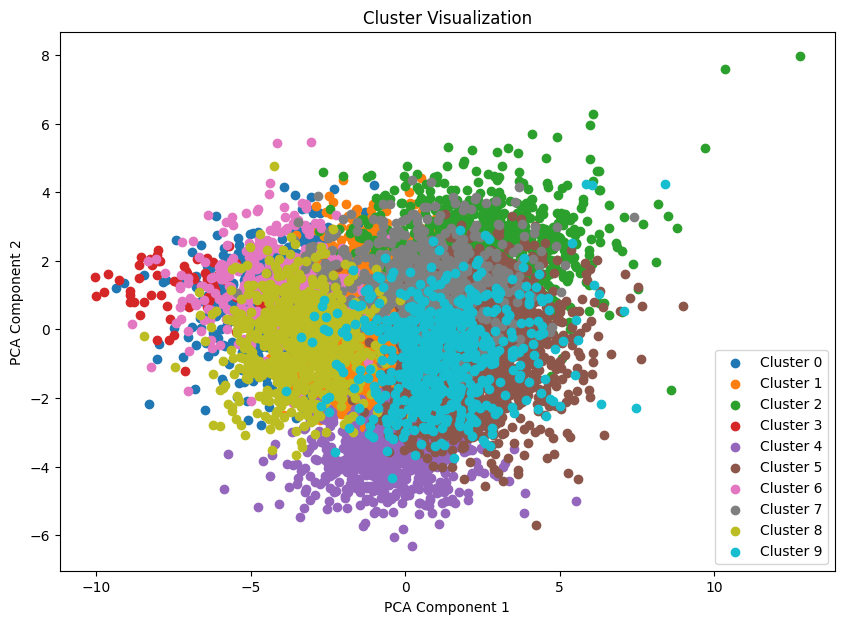

In [ ]:
'''from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# adding cluster label
dfX_est['cluster'] = clusters  # Add cluster labels to the DataFrame

# Plotting the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce data to two dimensions for plotting
reduced_data = pca.fit_transform(dfX_est.drop('cluster', axis=1))
plt.figure(figsize=(10, 7))

for cluster_label in np.unique(clusters):
    # Filter data points by cluster
    in_cluster = reduced_data[clusters == cluster_label]
    plt.scatter(in_cluster[:, 0], in_cluster[:, 1], label=f'Cluster {cluster_label}')

plt.title('Cluster Visualization')
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Filter and save specific clusters for Mukul
c1 = dfX_est[dfX_est['cluster'] == 1]
c2 = dfX_est[dfX_est['cluster'] == 2]

# Drop the 'cluster' column since no longer needed
dfX_est.drop('cluster', axis=1, inplace=True)'''

In [ ]:
c1.head()
c2.head()

mid,1,2,3,4,5,6,7,8,9,10,...,372,373,374,375,376,377,378,379,380,cluster
uid,,,,,,,,,,,,,,,,,,,,,
6,3.00,3.52,5.0,4.00,3.29,3.63,5.00,4.00,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,1
7,3.27,3.52,4.0,3.69,3.29,3.63,4.26,4.00,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,4.00,2.00,4.0,4.00,3.29,3.63,4.00,3.53,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,1
16,3.00,3.52,4.0,3.69,3.29,3.63,5.00,4.00,2.78,4.00,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,1


mid,1,2,3,4,5,6,7,8,9,10,...,372,373,374,375,376,377,378,379,380,cluster
uid,,,,,,,,,,,,,,,,,,,,,
1,3.27,3.52,2.0,3.69,3.29,3.63,5.00,3.53,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,2
12,3.27,3.52,3.0,3.69,3.29,3.63,4.26,3.53,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,5.00,2.00,4.0,3.69,3.29,3.63,3.00,2.00,2.78,3.37,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,2
44,3.00,3.00,3.0,2.00,3.29,3.00,3.00,3.00,2.78,2.00,...,3.53,3.02,3.58,2.19,3.02,2.54,3.12,3.35,3.81,2


<font color=green><h3><b>$\beta$. Apply truncated SVD</b><h3>

In [ ]:
def truncated_SVD(dfX_est, n, p, range = 5, k = 10, seed = 0)
  np.random.seed(seed)
  for _ in range(range):                             # apply truncated SVD approximation a few times
    U, D, Vt = svds(dfX_est.to_numpy(), k=k)               # find k eigenvectors (U,V) and eigenvalues (D)
    dfX_est.loc[1:n, 1:p] = U @ np.diag(D) @ Vt  # k-dimensional estimate (as np array) of dfM (we expect ratings' noise to reduce)
    mask = ~np.isnan(dfX)       # mask locations of NaN's
    dfX_est[mask] = dfX[mask]   # place original/known ratings back into estimated uid×mid matrix

dfX_est = truncated_SVD(dfX_est, n, p, 5, 10)

mid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
uid,,,,,,,,,,,,,,,,,,,,,
1,2.39,3.54,2.0,2.97,3.18,3.26,5.00,3.62,2.45,3.03,...,4.76,2.80,3.0,3.27,3.42,5.0,2.70,2.46,3.17,3.45
2,5.00,4.47,5.0,3.00,3.24,4.25,4.39,4.44,3.27,3.92,...,3.88,3.25,5.0,3.37,3.61,3.0,3.45,3.33,3.00,3.47


In [ ]:
# Submissions are scored on accuracy, not on continuous/regression error
dfX_est_L = dfX_est.unstack().reset_index().round(0).astype(int).rename(columns={0:'rtg'})  # tall format with integer ratings
dfK = dfX_est_L.merge(dfK, on=['mid','uid'], suffixes=['','_']).drop('rtg_', axis=1)
dfK.index = (dfK.uid-1)*dfK.mid.max()+dfK.mid
dfK['rtg'] = dfK['rtg'].clip(1, 5)  # restrict the range to 1,2,3,4,5 . Thanks to Yannis & Liz, See Piazza @67_f1
dfK

,mid,uid,rtg
1,1,1,2
147061,1,388,3
...,...,...,...
5568899,379,14655,3
5647180,380,14861,4


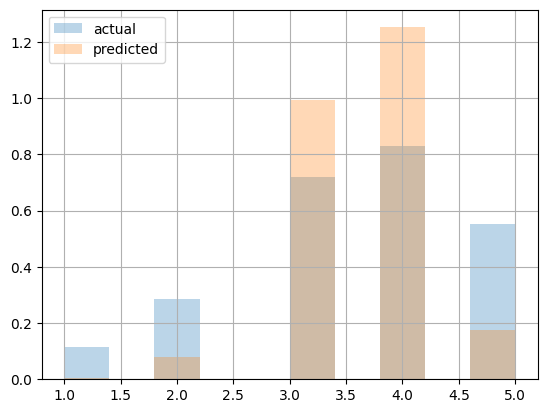

In [ ]:
# evaluate unconditional distributions of observed and predicted ratings. Learn from the differences to focus on wrong predictions
plt.subplot(1, 1, 1)
_ = df.rtg.dropna(axis=0).astype(int).hist(density=True, alpha=0.3);
_ = dfK.rtg.astype(int).hist(density=True, alpha=0.3);
_ = plt.legend(['actual','predicted']);

In [ ]:
ToCSV(dfK[['rtg']].sort_index(), '🍿DK_popcorn')

In [ ]:
!kaggle competitions submit -c 12feb24jh-netflix -f 🍿DK_popcorn.csv -m "Message"

100% 192k/192k [00:00<00:00, 867kB/s]
Successfully submitted to 12feb24jh-🍿Netflix

<font color=green><h3><b>$\gamma$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red>The preprocessing </b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\epsilon$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 22 sec


## 💡**Starter Ideas**

1. Tune model **hyperparameters**.
  1. SVD's $k$ might be user-perceived movie genres (perhaps, an average user categorizes movies into just 5 or 50 genres) [🎦](https://youtu.be/sooj-_bXWgk)
1. Try smarter **sampling** from the training set to avoid using all observations (due to time constraint)
  1. Some movies may have consistent high/low ratings and do not distinguish user preferences (just add to runtime)
1. Try SVD on groups (say movie genres) with the largest impact on overall accuracy
1. Try smarter initial imputation, perhaps, conditioned on movie genres or other observed features
1. Try clustering techniques from [SKL](https://scikit-learn.org/stable/modules/clustering.html)
1. Try engineering new features using Movies' data (`movies.csv`)
1. Try supervised approach on clusters or engineered features
1. Try shift/scale ratings. Recall: SVD seeks largest quadratic error from mean without shifting first, like variance does. Since $1^2\ll5^2$, SVD might work better for higher ratings.
  1. Note: the baseline model squeezes predictions towards ratings 3 and 4, which is not the original distribution.
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA. Are there movies that are liked by most viewers?
1. Try Robust PCA (RPC) [🎦](https://www.youtube.com/watch?v=yDpz0PqULXQ), [RPCA Github](https://github.com/dganguli/robust-pca)
1. Find polarized movies and tune for them (like "*Napoleon Dynamite*"). See [&#127910;](https://youtu.be/ImpV70uLxyw)
1. Try KNN [📄](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.596&rep=rep1&type=pdf), [📄](https://scholar.google.com/scholar?q=knn+netflix+prize)
1. Learn more methods to build/use latent representations [🎦](https://youtu.be/n3RKsY2H-NE),  [📄](https://ieeexplore.ieee.org/abstract/document/5197422), [📄](https://scholar.google.com/scholar?q=netflix+prize+challenge), [&#127910;](https://www.youtube.com/results?search_query=netflix+prize+svd), [📄](https://www.aaai.org/Papers/AAAI/2002/AAAI02-029.pdf),